# Cross-resonance gate between a transmon and a fluxonium: driving fluxonium

In this notebook we study the cross-resonance two-qubit gate between a transmon and a fluxonium. 

In [1]:
import numpy as np
from collections import defaultdict
import scipy.integrate
import time
import qutip as qtp
from scipy.optimize import minimize
import pysqkit
from pysqkit import QubitSystem
from pysqkit.drives.pulse_shapes import gaussian_top
from pysqkit.util.metrics import average_process_fidelity, \
    average_gate_fidelity
from pysqkit.util.phys import temperature_to_thermalenergy
import pysqkit.util.transformations as trf
from pysqkit.util.linalg import get_mat_elem
from pysqkit.util.hsbasis import weyl_by_index
import cmath
import multiprocessing
from functools import partial
import json
from typing import List, Dict, Callable
import matplotlib
matplotlib.rcParams['mathtext.fontset'] = 'cm'
import util_cr as util

In [2]:
def mu_yz_flx(comp_states, op) -> float:
    yz0 = get_mat_elem(op, comp_states['00'], comp_states['10'])
    yz1 = get_mat_elem(op, comp_states['01'], comp_states['11'] )
    return (np.imag(yz0 - yz1))/2

def mu_yi_flx(comp_states, op) -> float:
    yz0 = get_mat_elem(op, comp_states['00'], comp_states['10'] )
    yz1 = get_mat_elem(op, comp_states['01'], comp_states['11'] )
    return (np.imag(yz0 + yz1))/2

In [3]:
def func_to_minimize(
    pulse_time: list,
    t_rise: float,
    eps: float
) -> float:
    step = 1e-3
    n_points = int(pulse_time[0]/step)
    times = np.linspace(0, pulse_time[0], n_points)
    pulse = gaussian_top(times, t_rise, pulse_time[0])
    integral = scipy.integrate.simpson(2*np.pi*eps*pulse, times)
    return np.abs(integral - np.pi/2) 

In [4]:
def cry(theta):
    ide = np.identity(4)
    yz = np.kron(np.array([[0, -1j], [1j, 0]]), np.array([[1, 0], [0, -1]]))
    return np.cos(theta/2)*ide - 1j*np.sin(theta/2)*yz

def crx(theta):
    ide = np.identity(4)
    zx = np.kron(np.array([[0, 1], [1, 0]]), np.array([[1, 0], [0, -1]]))
    return np.cos(theta/2)*ide - 1j*np.sin(theta/2)*zx

def ry(theta):
    rot_y = np.cos(theta/2)*np.identity(2) - \
        1j*np.sin(theta/2)*np.array([[0, -1j], [1j, 0]])
    return np.kron(rot_y, np.identity(2))

In [5]:
def get_comp_states(coupled_sys):
    state_label = ["00", "01", "10", "11"]
    
    comp_states = {}
    for label in state_label:
        state_tmp = coupled_sys.state(label)[1]
        loc = np.argmax(np.abs(state_tmp))
        phase = cmath.phase(state_tmp[loc])
        state_tmp = np.exp(-1j*phase)*state_tmp
        comp_states[label] = state_tmp

    return comp_states

In [6]:
def get_leakage(
    gate_time: float, 
    system: QubitSystem,
    t_rise: float,
    eps_drive:float,
    freq_drive: float,
    comp_states_list: List 
):
    pts_per_drive_period = 5.0

    nb_points = int(gate_time*freq_drive*pts_per_drive_period)
    tlist = np.linspace(0, gate_time, nb_points)

    system['F'].drives['cr_drive_f'].set_params(phase=0, 
                                                time=tlist, 
                                                rise_time=t_rise, 
                                                pulse_time=gate_time, 
                                                amp=eps_drive, 
                                                freq=freq_drive)
    
    simu_opt = qtp.solver.Options()
    simu_opt.atol = 1e-12
    simu_opt.rtol = 1e-10

    env_syst = pysqkit.tomography.TomoEnv(system=system, 
                                          time=2*np.pi*tlist, 
                                          options=simu_opt, 
                                          with_noise=False)
    env_syst_noise = pysqkit.tomography.TomoEnv(system=system, 
                                          time=2*np.pi*tlist, 
                                          options=simu_opt, 
                                          with_noise=True)
    
    #n_process = 1
    avg_leakage = env_syst.leakage(comp_states_list)
    avg_leakage_noise = env_syst_noise.leakage(comp_states_list)
    
    result = {"gate_time": gate_time,
             "avg_leakage": avg_leakage, 
             "avg_leakage_noise": avg_leakage_noise}
    
    return result    

# Introducing the qubits and the coupled system

In [7]:
with open('../flx_transm_params.txt') as param_file:
    parameters_set = json.load(param_file)

In [8]:
temperature = 0.020 #0.020 # K
thermal_energy = temperature_to_thermalenergy(temperature) # kb T/h in GHz
d_comp = 4

p_set = "2"

#Transmon
levels_t = 3
transm = pysqkit.qubits.SimpleTransmon(
    label='T', 
    max_freq=parameters_set[p_set]["max_freq_t"] + 0.84, 
    anharm=parameters_set[p_set]["anharm_t"],
    diel_loss_tan=parameters_set[p_set]["diel_loss_tan_t"], #set to zero to check d_1 L1 = d_2 L2
    env_thermal_energy=thermal_energy,    
    dim_hilbert=levels_t,
    dephasing_times=None #parameters_set[p_set]["dephasing_times_t"]
)

#Fluxonium
levels_f = 6

flx = pysqkit.qubits.Fluxonium(
    label='F', 
    charge_energy=parameters_set[p_set]["charge_energy_f"], 
    induct_energy=parameters_set[p_set]["induct_energy_f"], 
    joseph_energy=parameters_set[p_set]["joseph_energy_f"], #8.0, 
    diel_loss_tan=parameters_set[p_set]["diel_loss_tan_f"], #set to zero to check d_1 L1 = d_2 L2
    env_thermal_energy=thermal_energy,
    dephasing_times=None #parameters_set[p_set]["dephasing_times_f"] #ns/2*np.pi 
)
flx.diagonalize_basis(levels_f)

# We also add a drive on the fluxonium
flx.add_drive(
    pysqkit.drives.microwave_drive,
    label='cr_drive_f',
    pulse=pysqkit.drives.pulses.cos_modulation,
    pulse_shape=pysqkit.drives.pulse_shapes.gaussian_top
)

d_leak = levels_t*levels_f - d_comp

jc = parameters_set[p_set]["jc"]
coupled_sys = transm.couple_to(flx, coupling=pysqkit.couplers.capacitive_coupling, strength=jc)

In [10]:
eps_drive = 0.6 #GHz
q_op = coupled_sys["F"].charge_op()
freq_drive = transm.max_freq
t_rise = 10.0 # [ns]
t_tot_0 = [40.0]
comp_states = get_comp_states(coupled_sys)
args_to_pass = (t_rise, np.abs(mu_yz_flx(comp_states, q_op))*eps_drive) 
minimization_result = minimize(func_to_minimize, t_tot_0, args=args_to_pass)
t_tot = minimization_result['x'][0]

In [11]:
transmon_freqs = np.linspace(3, 8, 200)

In [14]:
scan_results = defaultdict(list)

for transmon_freq in transmon_freqs:
    transm = pysqkit.qubits.SimpleTransmon(
        label='T', 
        max_freq = transmon_freq, 
        anharm=parameters_set[p_set]["anharm_t"],
        diel_loss_tan=parameters_set[p_set]["diel_loss_tan_t"],
        env_thermal_energy=thermal_energy,    
        dim_hilbert=levels_t,
        dephasing_times=None
    )
    
    coupled_sys = transm.couple_to(
        flx, 
        coupling=pysqkit.couplers.capacitive_coupling, 
        strength=jc
    )
    
    q_op = coupled_sys["F"].charge_op()
    
    comp_states = get_comp_states(coupled_sys)
    comp_states_list = list(comp_states.values())
    
    args_to_pass = (t_rise, np.abs(mu_yz_flx(comp_states, q_op))*eps_drive/2) #factor of two seems right here
    try:
        minimization_result = minimize(func_to_minimize, t_tot_0, args=args_to_pass)
        gate_time = minimization_result['x'][0] #1/(util.y_z_flx(coupled_sys, 'F')*eps_drive*4)  # [ns]
    except ValueError:
        scan_results["gate_time"].append(np.nan)
        scan_results["avg_leakage"].append(np.nan)
        scan_results["avg_leakage_noise"].append(np.nan)    
    
    try:
        result = get_leakage(
            gate_time = gate_time, 
            system = coupled_sys,
            t_rise = t_rise,
            eps_drive = eps_drive,
            freq_drive = transm.max_freq,
            comp_states_list=comp_states_list
        )

        for key, val in result.items():
            scan_results[key].append(val)
    except ValueError:
        scan_results["gate_time"].append(gate_time)
        scan_results["avg_leakage"].append(np.nan)
        scan_results["avg_leakage_noise"].append(np.nan)

ValueError: x and y must be the same size

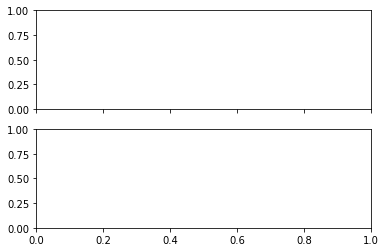

In [17]:
fig, (time_ax, leak_ax) = plt.subplots(nrows=2, sharex=True)
time_ax.scatter(transmon_freqs, scan_results["gate_time"])
leak_ax.scatter(transmon_freqs, scan_results["avg_leakage_noise"])

In [16]:
import matplotlib.pyplot as plt

In [18]:
transmon_freqs

array([3.        , 3.02512563, 3.05025126, 3.07537688, 3.10050251,
       3.12562814, 3.15075377, 3.1758794 , 3.20100503, 3.22613065,
       3.25125628, 3.27638191, 3.30150754, 3.32663317, 3.35175879,
       3.37688442, 3.40201005, 3.42713568, 3.45226131, 3.47738693,
       3.50251256, 3.52763819, 3.55276382, 3.57788945, 3.60301508,
       3.6281407 , 3.65326633, 3.67839196, 3.70351759, 3.72864322,
       3.75376884, 3.77889447, 3.8040201 , 3.82914573, 3.85427136,
       3.87939698, 3.90452261, 3.92964824, 3.95477387, 3.9798995 ,
       4.00502513, 4.03015075, 4.05527638, 4.08040201, 4.10552764,
       4.13065327, 4.15577889, 4.18090452, 4.20603015, 4.23115578,
       4.25628141, 4.28140704, 4.30653266, 4.33165829, 4.35678392,
       4.38190955, 4.40703518, 4.4321608 , 4.45728643, 4.48241206,
       4.50753769, 4.53266332, 4.55778894, 4.58291457, 4.6080402 ,
       4.63316583, 4.65829146, 4.68341709, 4.70854271, 4.73366834,
       4.75879397, 4.7839196 , 4.80904523, 4.83417085, 4.85929

In [20]:
scan_results["gate_time"]

[125.05400178111907,
 117.44916426175634,
 109.87130976755697,
 102.32165745465062,
 94.8015265664758,
 87.31238277607713,
 79.85591290723627,
 72.43415144455534,
 65.04970624319306,
 57.70618863834336,
 50.40910178072339,
 43.167875040962144,
 36.001211647996875,
 nan,
 36.001211647996875,
 nan,
 36.001211647996875,
 nan,
 36.001211647996875,
 nan,
 36.001211647996875,
 nan,
 36.001211647996875,
 nan,
 36.001211647996875,
 35.986524927223236,
 42.83467453287499,
 49.674828762573114,
 56.489134263910586,
 63.268390815526615,
 70.00708558042041,
 76.70148279319241,
 83.34878279873377,
 89.94671248916679,
 96.493309471382,
 102.9868008156241,
 109.42553138313683,
 115.80791941619995,
 122.13242810606717,
 128.3975466333971,
 134.6017772636983,
 140.7436262344689,
 146.82159719760193,
 152.8341864326915,
 158.7798791940404,
 164.6571468934408,
 170.46444494448167,
 176.20021101981078,
 181.8628635814481,
 187.45080073735286,
 192.96239925653208,
 198.3960136968211,
 203.74997571344565,
 2